In [1]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

In [2]:
seed = 543 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.set_deterministic(True)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

引入 OpenAI 的 gym，並建立一個 Lunar Lander 環境。

In [3]:
%%capture
import gym
import random
import numpy as np

env = gym.make('LunarLander-v2')

fix(env, seed)

### Observation / State
首先，我們可以看看 environment 回傳給 agent 的 observation 究竟是長什麼樣子的資料：

In [6]:
print(env.observation_space)

Box(-inf, inf, (8,), float32)


Box(8,) 說明我們會拿到 8 維的向量作為 observation，其中包含：垂直及水平座標、速度、角度、加速度等等，這部分我們就不細說。

### Action

而在 agent 得到 observation 和 reward 以後，能夠採取的動作有：

In [8]:
print(env.action_space)

Discrete(4)


Discrete(4) 說明 agent 可以採取四種離散的行動：

0 代表不採取任何行動
2 代表主引擎向下噴射
1, 3 則是向左右噴射
接下來，我們嘗試讓 agent 與 environment 互動。 在進行任何操作前，建議先呼叫 reset() 函式讓整個「環境」重置。 而這個函式同時會回傳「環境」最初始的狀態。

In [9]:
initial_state = env.reset()
print(initial_state)

[ 0.00396109  1.4083536   0.40119505 -0.11407257 -0.00458307 -0.09087662
  0.          0.        ]


接著，我們試著從 agent 的四種行動空間中，隨機採取一個行動

In [10]:
random_action = env.action_space.sample()
print(random_action)

0


再利用 step() 函式讓 agent 根據我們隨機抽樣出來的 random_action 動作。 而這個函式會回傳四項資訊：

observation / state
reward
完成與否
其餘資訊

In [13]:
observation, reward, done, info = env.step(random_action)
print(reward)
print(done)

-1.110938286428194
False


第一項資訊 observation 即為 agent 採取行動之後，agent 對於環境的 observation 或者說環境的 state 為何。 而第三項資訊 done 則是 True 或 False 的布林值，當登月小艇成功著陸或是不幸墜毀時，代表這個回合（episode）也就跟著結束了，此時 step() 函式便會回傳 done = True，而在那之前，done 則保持 False。


### Reward
而「環境」給予的 reward 大致是這樣計算：

- 小艇墜毀得到 -100 分
- 小艇在黃旗幟之間成功著地則得 100~140 分
- 噴射主引擎（向下噴火）每次 -0.3 分
- 小艇最終完全靜止則再得 100 分
- 小艇每隻腳碰觸地面 +10 分
>Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame.

### Random Agent
最後，在進入實做之前，我們就來看看這樣一個 random agent 能否成功登陸月球：

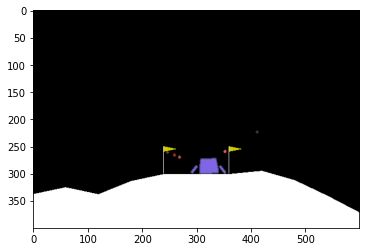

In [14]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

### Policy Gradient
現在來搭建一個簡單的 policy network。 我們預設模型的輸入是 8-dim 的 observation，輸出則是離散的四個動作之一：

In [15]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

再來，搭建一個簡單的 agent，並搭配上方的 policy network 來採取行動。 這個 agent 能做到以下幾件事：

* learn()：從記下來的 log probabilities 及 rewards 來更新 policy network。
* sample()：從 environment 得到 observation 之後，利用 policy network 得出應該採取的行動。 而此函式除了回傳抽樣出來的 action，也會回傳此次抽樣的 log probabilities。

In [16]:
class PolicyGradientAgent():
    
    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)
         
    def forward(self, state):
        return self.network(state)
    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum() # You don't need to revise this to pass simple baseline (but you can)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

    def save(self, PATH): # You should not revise this
        Agent_Dict = {
            "network" : self.network.state_dict(),
            "optimizer" : self.optimizer.state_dict()
        }
        torch.save(Agent_Dict, PATH)

    def load(self, PATH): # You should not revise this
        checkpoint = torch.load(PATH)
        self.network.load_state_dict(checkpoint["network"])
        #如果要儲存過程或是中斷訓練後想繼續可以用喔 ^_^
        self.optimizer.load_state_dict(checkpoint["optimizer"])

最後，建立一個 network 和 agent，就可以開始進行訓練了。

In [17]:
network = PolicyGradientNetwork()
agent = PolicyGradientAgent(network)
#agent = PolicyGradientAgent()

### 訓練 Agent
現在我們開始訓練 agent。 透過讓 agent 和 environment 互動，我們記住每一組對應的 log probabilities 及 reward，並在成功登陸或者不幸墜毀後，回放這些「記憶」來訓練 policy network。

In [7]:
import time
start = time.time()

In [19]:
agent.network.train()  # 訓練前，先確保 network 處在 training 模式
EPISODE_PER_BATCH = 5  # 每蒐集 5 個 episodes 更新一次 agent
NUM_BATCH = 400        # 總共更新 400 次

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH):
        
        state = env.reset()
        total_reward, total_step = 0, 0
        seq_rewards = []
        while True:

            action, log_prob = agent.sample(state) # at , log(at|st)
            next_state, reward, done, _ = env.step(action)

            log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
            # seq_rewards.append(reward)
            state = next_state
            total_reward += reward
            total_step += 1
            rewards.append(reward) #改這裡
            # ! 重要 ！
            # 現在的reward 的implementation 為每個時刻的瞬時reward, 給定action_list : a1, a2, a3 ......
            #                                                       reward :     r1, r2 ,r3 ......
            # medium：將reward調整成accumulative decaying reward, 給定action_list : a1,                         a2,                           a3 ......
            #                                                       reward :     r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,r3+0.99*r4+0.99^2*r5+ ......
            # boss : implement DQN
            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                break

    print(f"rewards looks like ", np.shape(rewards))  
    print(f"log_probs looks like ", np.shape(log_probs))     
    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 更新網路
    # rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # 將 reward 正規標準化
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))
    print("logs prob looks like ", torch.stack(log_probs).size())
    print("torch.from_numpy(rewards) looks like ", torch.from_numpy(rewards).size())

end = time.time()


  0%|          | 0/400 [00:00<?, ?it/s]

rewards looks like  (440,)
log_probs looks like  (440,)
logs prob looks like  torch.Size([440])
torch.from_numpy(rewards) looks like  torch.Size([440])
rewards looks like  (527,)
log_probs looks like  (527,)
logs prob looks like  torch.Size([527])
torch.from_numpy(rewards) looks like  torch.Size([527])
rewards looks like  (455,)
log_probs looks like  (455,)
logs prob looks like  torch.Size([455])
torch.from_numpy(rewards) looks like  torch.Size([455])
rewards looks like  (440,)
log_probs looks like  (440,)
logs prob looks like  torch.Size([440])
torch.from_numpy(rewards) looks like  torch.Size([440])
rewards looks like  (452,)
log_probs looks like  (452,)
logs prob looks like  torch.Size([452])
torch.from_numpy(rewards) looks like  torch.Size([452])
rewards looks like  (522,)
log_probs looks like  (522,)
logs prob looks like  torch.Size([522])
torch.from_numpy(rewards) looks like  torch.Size([522])
rewards looks like  (400,)
log_probs looks like  (400,)
logs prob looks like  torch.Size

rewards looks like  (835,)
log_probs looks like  (835,)
logs prob looks like  torch.Size([835])
torch.from_numpy(rewards) looks like  torch.Size([835])
rewards looks like  (587,)
log_probs looks like  (587,)
logs prob looks like  torch.Size([587])
torch.from_numpy(rewards) looks like  torch.Size([587])
rewards looks like  (517,)
log_probs looks like  (517,)
logs prob looks like  torch.Size([517])
torch.from_numpy(rewards) looks like  torch.Size([517])
rewards looks like  (811,)
log_probs looks like  (811,)
logs prob looks like  torch.Size([811])
torch.from_numpy(rewards) looks like  torch.Size([811])
rewards looks like  (616,)
log_probs looks like  (616,)
logs prob looks like  torch.Size([616])
torch.from_numpy(rewards) looks like  torch.Size([616])
rewards looks like  (1204,)
log_probs looks like  (1204,)
logs prob looks like  torch.Size([1204])
torch.from_numpy(rewards) looks like  torch.Size([1204])
rewards looks like  (579,)
log_probs looks like  (579,)
logs prob looks like  torch.

rewards looks like  (701,)
log_probs looks like  (701,)
logs prob looks like  torch.Size([701])
torch.from_numpy(rewards) looks like  torch.Size([701])
rewards looks like  (795,)
log_probs looks like  (795,)
logs prob looks like  torch.Size([795])
torch.from_numpy(rewards) looks like  torch.Size([795])
rewards looks like  (722,)
log_probs looks like  (722,)
logs prob looks like  torch.Size([722])
torch.from_numpy(rewards) looks like  torch.Size([722])
rewards looks like  (697,)
log_probs looks like  (697,)
logs prob looks like  torch.Size([697])
torch.from_numpy(rewards) looks like  torch.Size([697])
rewards looks like  (718,)
log_probs looks like  (718,)
logs prob looks like  torch.Size([718])
torch.from_numpy(rewards) looks like  torch.Size([718])
rewards looks like  (684,)
log_probs looks like  (684,)
logs prob looks like  torch.Size([684])
torch.from_numpy(rewards) looks like  torch.Size([684])
rewards looks like  (710,)
log_probs looks like  (710,)
logs prob looks like  torch.Size

rewards looks like  (1777,)
log_probs looks like  (1777,)
logs prob looks like  torch.Size([1777])
torch.from_numpy(rewards) looks like  torch.Size([1777])
rewards looks like  (1468,)
log_probs looks like  (1468,)
logs prob looks like  torch.Size([1468])
torch.from_numpy(rewards) looks like  torch.Size([1468])
rewards looks like  (476,)
log_probs looks like  (476,)
logs prob looks like  torch.Size([476])
torch.from_numpy(rewards) looks like  torch.Size([476])
rewards looks like  (544,)
log_probs looks like  (544,)
logs prob looks like  torch.Size([544])
torch.from_numpy(rewards) looks like  torch.Size([544])
rewards looks like  (687,)
log_probs looks like  (687,)
logs prob looks like  torch.Size([687])
torch.from_numpy(rewards) looks like  torch.Size([687])
rewards looks like  (1642,)
log_probs looks like  (1642,)
logs prob looks like  torch.Size([1642])
torch.from_numpy(rewards) looks like  torch.Size([1642])
rewards looks like  (1060,)
log_probs looks like  (1060,)
logs prob looks li

rewards looks like  (1658,)
log_probs looks like  (1658,)
logs prob looks like  torch.Size([1658])
torch.from_numpy(rewards) looks like  torch.Size([1658])
rewards looks like  (1614,)
log_probs looks like  (1614,)
logs prob looks like  torch.Size([1614])
torch.from_numpy(rewards) looks like  torch.Size([1614])
rewards looks like  (883,)
log_probs looks like  (883,)
logs prob looks like  torch.Size([883])
torch.from_numpy(rewards) looks like  torch.Size([883])
rewards looks like  (1433,)
log_probs looks like  (1433,)
logs prob looks like  torch.Size([1433])
torch.from_numpy(rewards) looks like  torch.Size([1433])
rewards looks like  (2336,)
log_probs looks like  (2336,)
logs prob looks like  torch.Size([2336])
torch.from_numpy(rewards) looks like  torch.Size([2336])
rewards looks like  (601,)
log_probs looks like  (601,)
logs prob looks like  torch.Size([601])
torch.from_numpy(rewards) looks like  torch.Size([601])
rewards looks like  (1643,)
log_probs looks like  (1643,)
logs prob look

rewards looks like  (1032,)
log_probs looks like  (1032,)
logs prob looks like  torch.Size([1032])
torch.from_numpy(rewards) looks like  torch.Size([1032])
rewards looks like  (1818,)
log_probs looks like  (1818,)
logs prob looks like  torch.Size([1818])
torch.from_numpy(rewards) looks like  torch.Size([1818])
rewards looks like  (1418,)
log_probs looks like  (1418,)
logs prob looks like  torch.Size([1418])
torch.from_numpy(rewards) looks like  torch.Size([1418])
rewards looks like  (1462,)
log_probs looks like  (1462,)
logs prob looks like  torch.Size([1462])
torch.from_numpy(rewards) looks like  torch.Size([1462])
rewards looks like  (2911,)
log_probs looks like  (2911,)
logs prob looks like  torch.Size([2911])
torch.from_numpy(rewards) looks like  torch.Size([2911])
rewards looks like  (1316,)
log_probs looks like  (1316,)
logs prob looks like  torch.Size([1316])
torch.from_numpy(rewards) looks like  torch.Size([1316])
rewards looks like  (2006,)
log_probs looks like  (2006,)
logs p

rewards looks like  (1070,)
log_probs looks like  (1070,)
logs prob looks like  torch.Size([1070])
torch.from_numpy(rewards) looks like  torch.Size([1070])
rewards looks like  (1355,)
log_probs looks like  (1355,)
logs prob looks like  torch.Size([1355])
torch.from_numpy(rewards) looks like  torch.Size([1355])
rewards looks like  (2579,)
log_probs looks like  (2579,)
logs prob looks like  torch.Size([2579])
torch.from_numpy(rewards) looks like  torch.Size([2579])
rewards looks like  (2010,)
log_probs looks like  (2010,)
logs prob looks like  torch.Size([2010])
torch.from_numpy(rewards) looks like  torch.Size([2010])
rewards looks like  (1754,)
log_probs looks like  (1754,)
logs prob looks like  torch.Size([1754])
torch.from_numpy(rewards) looks like  torch.Size([1754])
rewards looks like  (1382,)
log_probs looks like  (1382,)
logs prob looks like  torch.Size([1382])
torch.from_numpy(rewards) looks like  torch.Size([1382])
rewards looks like  (1127,)
log_probs looks like  (1127,)
logs p

rewards looks like  (2078,)
log_probs looks like  (2078,)
logs prob looks like  torch.Size([2078])
torch.from_numpy(rewards) looks like  torch.Size([2078])
rewards looks like  (1841,)
log_probs looks like  (1841,)
logs prob looks like  torch.Size([1841])
torch.from_numpy(rewards) looks like  torch.Size([1841])
rewards looks like  (1994,)
log_probs looks like  (1994,)
logs prob looks like  torch.Size([1994])
torch.from_numpy(rewards) looks like  torch.Size([1994])
rewards looks like  (1406,)
log_probs looks like  (1406,)
logs prob looks like  torch.Size([1406])
torch.from_numpy(rewards) looks like  torch.Size([1406])
rewards looks like  (1341,)
log_probs looks like  (1341,)
logs prob looks like  torch.Size([1341])
torch.from_numpy(rewards) looks like  torch.Size([1341])
rewards looks like  (2019,)
log_probs looks like  (2019,)
logs prob looks like  torch.Size([2019])
torch.from_numpy(rewards) looks like  torch.Size([2019])
rewards looks like  (1265,)
log_probs looks like  (1265,)
logs p

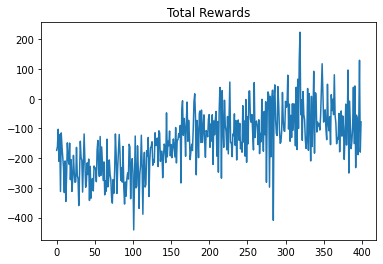

In [20]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

另外，avg_final_reward 代表的是多個回合的平均 final rewards，而 final reward 即是 agent 在單一回合中拿到的最後一個 reward。 如果同學們還記得環境給予登月小艇 reward 的方式，便會知道，不論回合的最後小艇是不幸墜毀、飛出畫面、或是靜止在地面上，都會受到額外地獎勵或處罰。 也因此，final reward 可被用來觀察 agent 的「著地」是否順利等資訊。

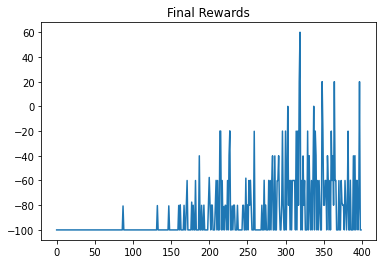

In [21]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

In [22]:
print(f"total time is {end-start} sec")

total time is 1276.0784616470337 sec


### 測試

/home/docker/.local/lib/python3.6/site-packages/torch/__init__.py:422: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  "torch.set_deterministic is deprecated and will be removed in a future "


255.01322592726896
length of actions is  563
-7.426899374267279
length of actions is  175
-196.93449573188605
length of actions is  269
239.12842717649994
length of actions is  784
196.95186652493925
length of actions is  581


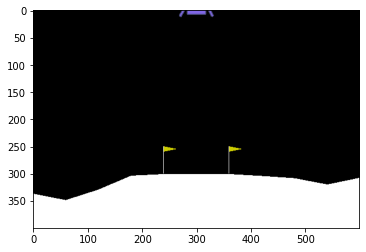

In [23]:
fix(env, seed)
agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式
NUM_OF_TEST = 5 # Do not revise it !!!!!
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()

  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  while not done:
      action, _ = agent.sample(state)
      actions.append(action)
      state, reward, done, _ = env.step(action)

      total_reward += reward

      #img.set_data(env.render(mode='rgb_array'))
      #display.display(plt.gcf())
      #display.clear_output(wait=True)
  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) #儲存你測試的結果
  print("length of actions is ", len(actions))

In [24]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : 97.35


Action list 的長相

In [25]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

Action list looks like  [[1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 3, 3, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 0, 0, 2, 3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 3, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0,

/home/docker/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Action 的分布

In [26]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

{1: 431, 2: 780, 3: 424, 0: 737}


儲存 Model Testing的結果

In [27]:
PATH = "Action_List_test.npy" # 可以改成你想取的名字或路徑
np.save(PATH ,np.array(action_list))

/home/docker/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


### Server 測試
到時候下面會是我們Server上測試的環境，可以給大家看一下自己的表現如何

Your reward is : 255.01
Your reward is : -7.43
Your reward is : -196.93
Your reward is : 239.13
Your reward is : 196.95


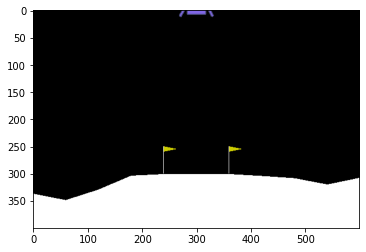

In [28]:
action_list = np.load(PATH,allow_pickle=True) #到時候你上傳的檔案
seed = 543 #到時候測試的seed 請不要更改
fix(env, seed)

agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式

test_total_reward = []
for actions in action_list:
  state = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  # while not done:
  done_count = 0
  for action in actions:
      # action, _ = agent1.sample(state)
      state, reward, done, _ = env.step(action)
      done_count += 1
      total_reward += reward
      if done:
        
        break
    #   img.set_data(env.render(mode='rgb_array'))
    #   display.display(plt.gcf())
    #   display.clear_output(wait=True)
  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

### 你的成績

In [29]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : 97.35
